In [1]:
#  take a set of pmid-clusters and build word2vec models for each

#     sample 1    cluster a, b, c, d

# todo think about how to do statistics on these  (using the other samples perhaps?)

In [7]:
import pymysql
import pickle
import json

import numpy as np
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['svg.fonttype'] = 'none'

import time
import hdbscan

import spacy
from gensim.models import Word2Vec

import random
import re
from pmids2vec import pmids2vec

import igraph

# train a word2vec model for several pre-defined clusters

In [3]:
# todo force samples to have the same size, test impact of vocabulary ? 
#    or maybe just test variance over multiple samplesets to check for effects of sample size asymmetry

# load pmids

sample_id = 1
model_names = []

clustered_pmids_path = 'data_processing/test_clusters2018.json'
with open(clustered_pmids_path, 'r') as f:
    data = json.load(f)
    
#print(data['pmids'])   # i_sample, i_cluster

sample_pmids = []


clustered_pmids = data['pmids'][str(sample_id)]
for cluster_id_str, pmids_list in clustered_pmids.items():
    
    model_export_path = 'data_processing/testmodel_cluster' + cluster_id_str + '.model'
    model_names.append(model_export_path)
    
    print('calling pmids2vec...')
    pmids2vec(pmids_list, model_export_path)

#print(data['pmids'])



calling pmids2vec...
SQL join executed in 31.173333168029785 s
SQL results fetched and cast in 0.0007398128509521484 s
training word2vec model...
params: 20 dimensions, 5 window size, 10 min count
elapsed: 0.3906702995300293
calling pmids2vec...
SQL join executed in 30.00709867477417 s
SQL results fetched and cast in 0.00033736228942871094 s
training word2vec model...
params: 20 dimensions, 5 window size, 10 min count
elapsed: 0.21491599082946777
calling pmids2vec...
SQL join executed in 30.556307315826416 s
SQL results fetched and cast in 0.00014472007751464844 s
training word2vec model...
params: 20 dimensions, 5 window size, 10 min count
elapsed: 0.150437593460083
calling pmids2vec...
SQL join executed in 29.779287815093994 s
SQL results fetched and cast in 0.00017881393432617188 s
training word2vec model...
params: 20 dimensions, 5 window size, 10 min count
elapsed: 0.1444103717803955


In [4]:
# load in the models that were just created

models = {}
for model_name in model_names:
    
    short_name = str.split(model_name,'/')[-1]
    print(short_name)
    
    model = Word2Vec.load(model_name)
    models[short_name] = model
    print('{} words '.format(len(model.wv.vocab)))
    print()
    

testmodel_cluster0.model
1155 words 

testmodel_cluster1.model
549 words 

testmodel_cluster2.model
337 words 

testmodel_cluster3.model
311 words 



In [5]:
# visualize the models

full_vocabulary = []
common_vocabulary = []

for name, model in models.items():
    
    this_vocabulary = [word for word in model.wv.vocab.keys()]
    
    full_vocabulary.extend(this_vocabulary)
    
    if common_vocabulary: # check that the list has been initialized
        common_vocabulary = list( set(common_vocabulary).intersection(set(this_vocabulary)) )
    else:
        common_vocabulary = this_vocabulary  # first loop
    
full_vocabulary = list(set(full_vocabulary))  # get unique strings

print("length of full vocabulary: {} ".format(len(full_vocabulary)))
print("length of common vocabulary: {} ".format(len(common_vocabulary)))

length of full vocabulary: 1588 
length of common vocabulary: 105 


(105, 105)
(105, 105)
(105, 105)
(105, 105)


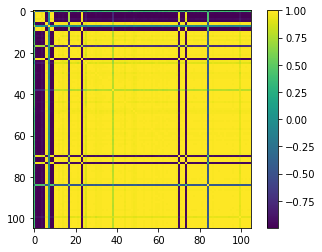

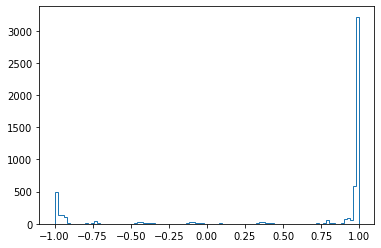

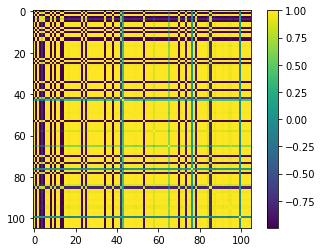

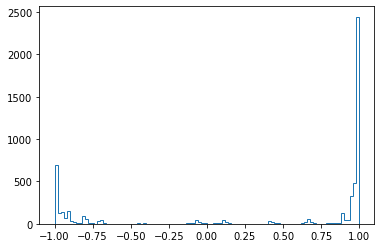

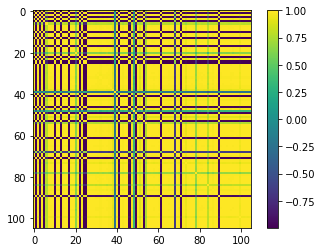

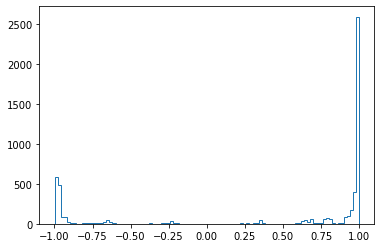

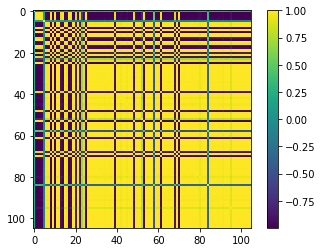

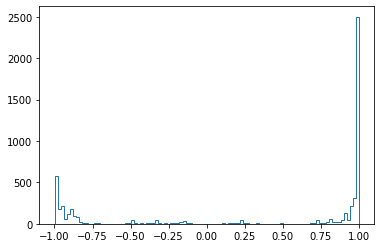

In [23]:
# build adjacency matrix for common network

ggg = {}
for idx, model in enumerate(models.values()):
    
    # the number of nodes is small so we can do this with mat mul
    D = np.shape(model.wv[common_vocabulary[0]])[0]
    embedding_samples = np.zeros( (len(common_vocabulary), D) )
    
    for i_word, word in enumerate(common_vocabulary):
        embedding_samples[i_word,:] = model.wv[word]
        
    # demean
    #for i_dim in range(D):
    #    embedding_samples[:, i_dim] -= np.mean(embedding_samples[:,i_dim])
    for i_word, word in enumerate(common_vocabulary):
        embedding_samples[i_word,:] -= np.mean(embedding_samples,0)
        
    # normalize all vectors to the hypersphere
    for i_row,row in enumerate(embedding_samples):
        embedding_samples[i_row,:] /= np.linalg.norm(row,2)
        
    W = np.matmul(embedding_samples, embedding_samples.T)
    print(np.shape(W))
    
    plt.figure()
    plt.imshow(W)
    plt.colorbar()
    
    plt.figure()
    plt.hist(np.tril(W,k=-1)[np.tril(W,k=-1).nonzero()].flatten(),histtype='step', bins=100)
    
    W_binary = (W > 0).tolist()
    ggg[idx] = igraph.Graph.Adjacency(W_binary)  # define connections
    ggg[idx].es['weight'] = W[W.nonzero()]
    

In [ ]:


#  https://stackoverflow.com/questions/29655111/igraph-graph-from-numpy-or-pandas-adjacency-matrix


In [ ]:
# plot common network (look for different neighborhood patterns)

In [ ]:
# show top words and unique words

(1155, 1155)
(549, 549)
(337, 337)
(311, 311)


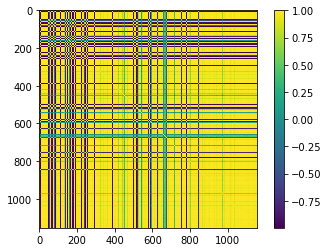

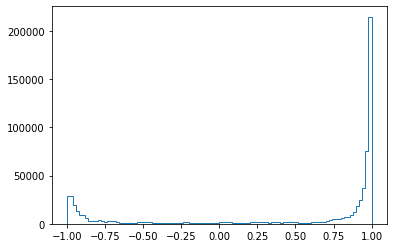

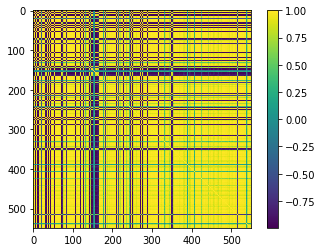

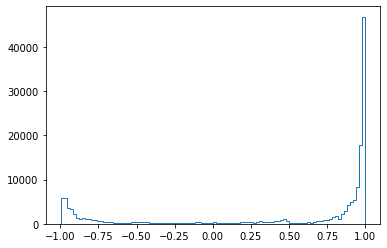

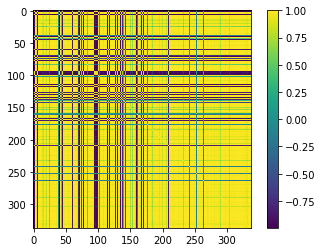

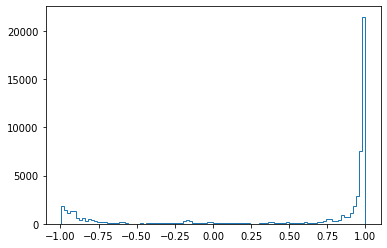

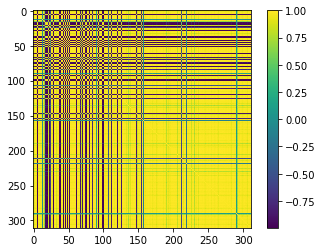

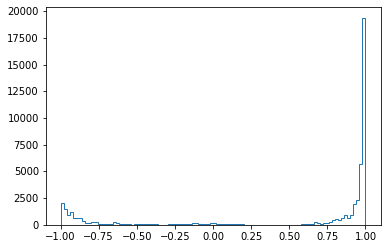

In [19]:
# plot full network for each cluster

# compare range to range of shared subnetwork

#ggg = {}
for idx, model in enumerate(models.values()):
    
    # the number of nodes is small so we can do this with mat mul
    D = np.shape(model.wv[common_vocabulary[0]])[0]
    
    embedding_samples = np.zeros( (len(model.wv.vocab), D) )
    
    for i_word, word in enumerate(model.wv.vocab):
        embedding_samples[i_word,:] = model.wv[word]
        
    for i_word, word in enumerate(model.wv.vocab):
        embedding_samples[i_word,:] -= np.mean(embedding_samples,0)
        
    # normalize all vectors to the hypersphere
    for i_row,row in enumerate(embedding_samples):
        embedding_samples[i_row,:] /= np.linalg.norm(row,2)
        
    W = np.matmul(embedding_samples, embedding_samples.T)
    print(np.shape(W))
    
    plt.figure()
    plt.imshow(W)
    plt.colorbar()
    
    plt.figure()
    plt.hist(np.tril(W,k=-1)[np.tril(W,k=-1).nonzero()].flatten(),histtype='step', bins=100)
    
    #W_binary = (W > 0).tolist()
    #ggg[idx] = igraph.Graph.Adjacency(W_binary)  # define connections
    #ggg[idx].es['weight'] = W[W.nonzero()]